In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import properscoring as ps
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from helper_functions import optimize_paras_onefit, llscore
from crpsmixture import smooth_crps
import multiprocessing as mp
import time
import random
from itertools import product
import isodisreg 
from isodisreg import idr

In [2]:
idx = {"u10":0, "v10":1, "t2m":2, "t850":3, "z500":4, "wind":5}

In [3]:
# Open dataset
metrics = xr.open_dataset("crps_metrics.h5")
metrics

<xarray.Dataset>
Dimensions:      (phony_dim_0: 6, phony_dim_1: 120, phony_dim_2: 130,
                  phony_dim_3: 32)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3
Data variables:
    climatology  (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    ens_fc       (phony_dim_3, phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    eq           (phony_dim_3, phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    eq_ens       (phony_dim_3, phony_dim_0, phony_dim_1, phony_dim_2) float32 ...

In [4]:
climatology = metrics.climatology
ens_fc = metrics.ens_fc
easyuq = metrics.eq
eq_ens = metrics.eq_ens

In [5]:
land_sea_mask = np.load("../../data/stats_v0/land_sea_mask.npy")
lat_slice = slice(110,230)
lon_slice = np.append(np.arange(1370,1440), np.arange(0,60))
ls_mask = land_sea_mask[lat_slice, lon_slice]

# Analyze CRPS

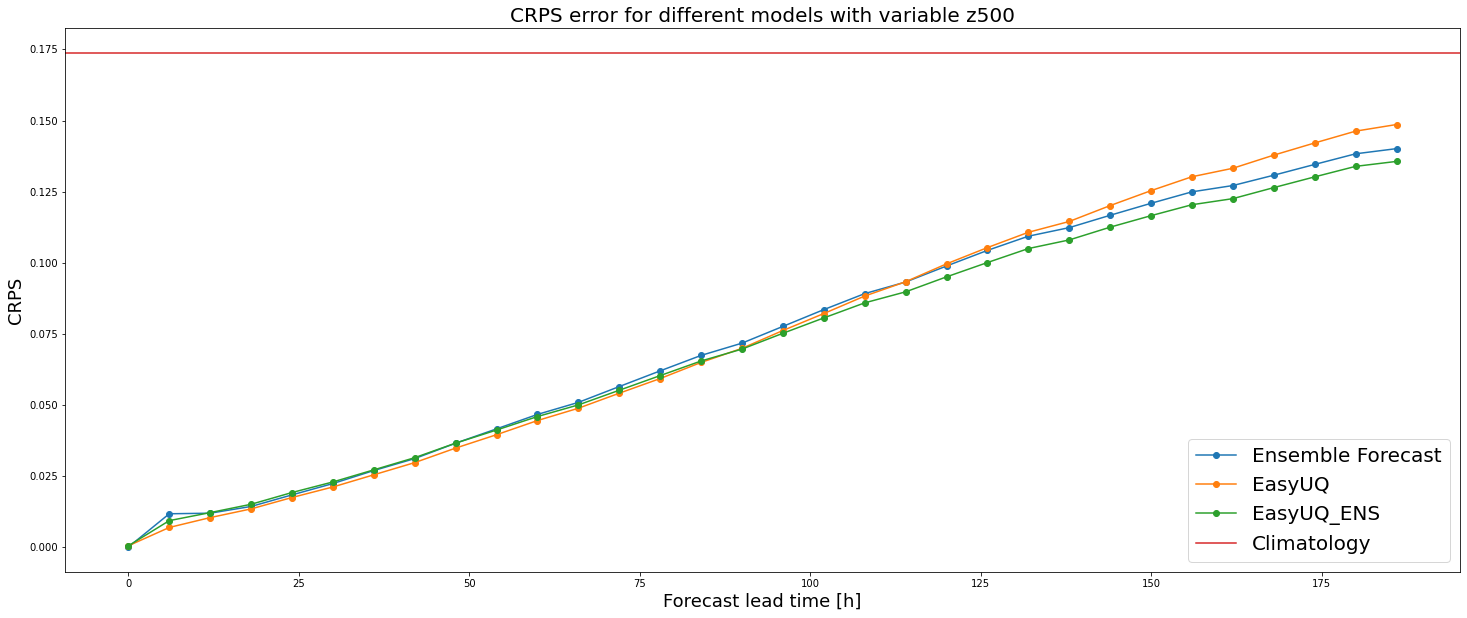

In [14]:
var = "z500"

fig, axs = plt.subplots(figsize = (25,10))
hour_range = np.arange(0, ens_fc.shape[0])*6
#axs.plot(hour_range, raw_fc.isel(phony_dim_1 = idx[var]), marker = "o")
axs.plot(hour_range, ens_fc.isel(phony_dim_0 = idx[var]).mean(dim = ["phony_dim_1", "phony_dim_2"]), marker = "o")
axs.plot(hour_range, easyuq.isel(phony_dim_0 = idx[var]).mean(dim = ["phony_dim_1", "phony_dim_2"]), marker = "o")
axs.plot(hour_range, eq_ens.isel(phony_dim_0 = idx[var]).mean(dim = ["phony_dim_1", "phony_dim_2"]), marker = "o")
axs.axhline(climatology.isel(phony_dim_0 = idx[var]).mean(dim = ["phony_dim_1", "phony_dim_2"]), color = "tab:red")


axs.set_xlabel("Forecast lead time [h]", fontsize = 18)
axs.set_ylabel("CRPS", fontsize = 18)
axs.set_title(f"CRPS error for different models with variable {var}", fontsize = 20)
axs.legend(labels = ["Ensemble Forecast", "EasyUQ", "EasyUQ_ENS", "Climatology"], fontsize = 20)

# Analyze Weighted CRPS

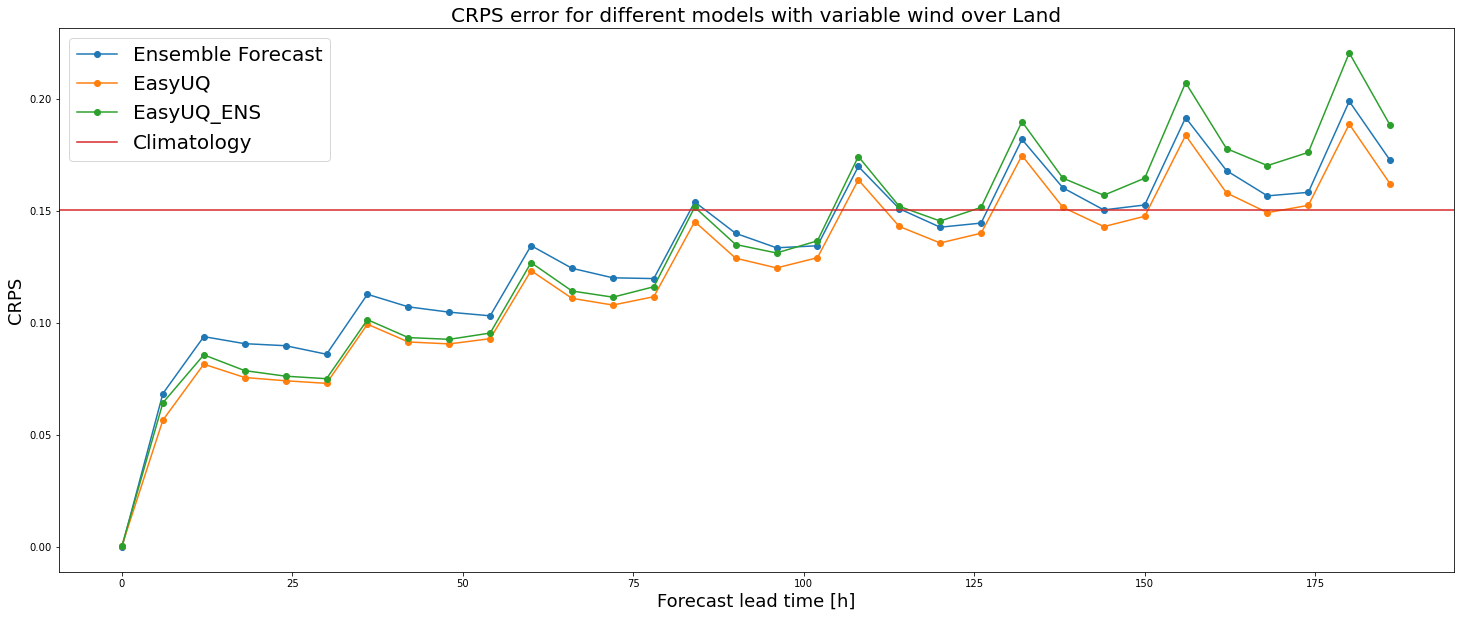

In [9]:
var = "wind"

mask = ls_mask # 1-ls_mask for sea

fig, axs = plt.subplots(figsize = (25,10))
hour_range = np.arange(0, ens_fc.shape[0])*6
#axs.plot(hour_range, raw_fc.isel(phony_dim_1 = idx[var]), marker = "o")
axs.plot(hour_range, np.average(ens_fc.isel(phony_dim_0 = idx[var]), axis = (1,2), weights = np.repeat(np.expand_dims(mask,axis = 0), 32, axis = 0)), marker = "o")
axs.plot(hour_range, np.average(easyuq.isel(phony_dim_0 = idx[var]), axis = (1,2), weights = np.repeat(np.expand_dims(mask,axis = 0), 32, axis = 0)), marker = "o")
axs.plot(hour_range, np.average(eq_ens.isel(phony_dim_0 = idx[var]), axis = (1,2), weights = np.repeat(np.expand_dims(mask,axis = 0), 32, axis = 0)), marker = "o")
axs.axhline(np.average(climatology.isel(phony_dim_0 = idx[var]), axis = (0,1), weights = mask), color = "tab:red")


axs.set_xlabel("Forecast lead time [h]", fontsize = 18)
axs.set_ylabel("CRPS", fontsize = 18)
axs.set_title(f"CRPS error for different models with variable {var} over Land", fontsize = 20)
axs.legend(labels = ["Ensemble Forecast", "EasyUQ", "EasyUQ_ENS", "Climatology"], fontsize = 20)

# Analyze EasyUQ metrics

Text(0.5, 1.0, 'Ensemble Forecast')

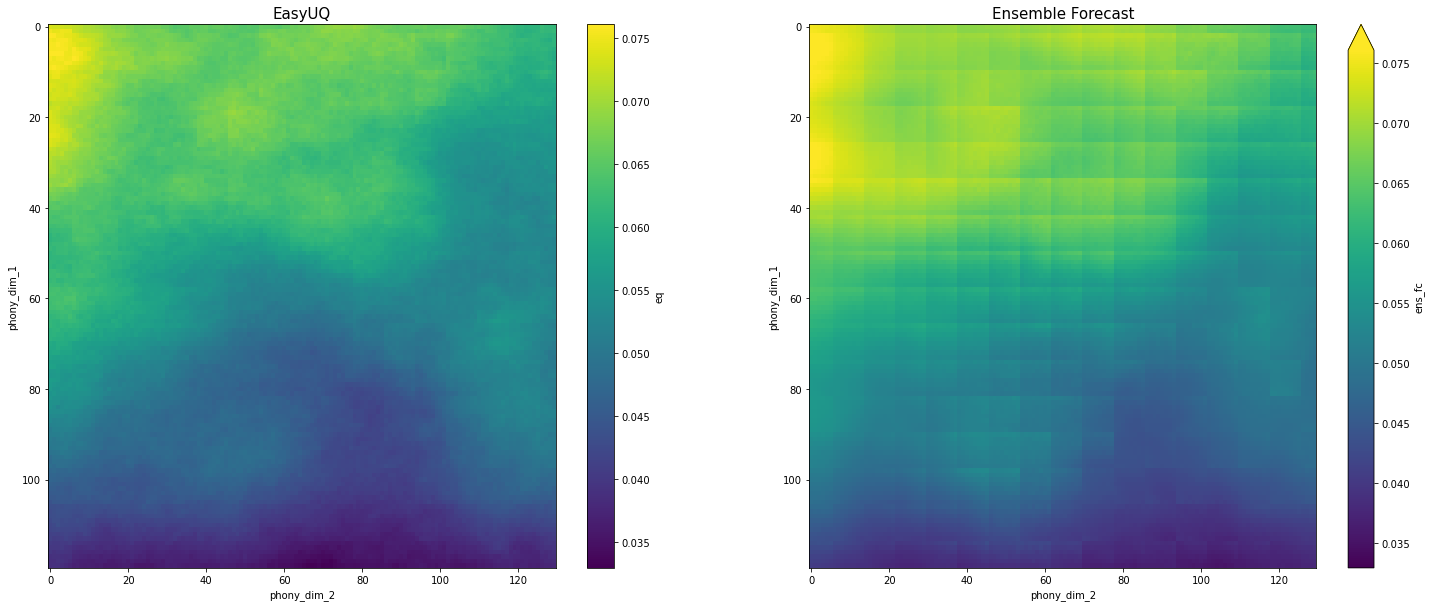

In [92]:
var = "z500"
step = 12
max_crps = np.min(([easyuq.isel(phony_dim_3 = step, phony_dim_0 = idx[var]).max(), ens_fc.isel(phony_dim_3 = step, phony_dim_0 = idx[var]).max()]))
min_crps = np.min(([easyuq.isel(phony_dim_3 = step, phony_dim_0 = idx[var]).min(), ens_fc.isel(phony_dim_3 = step, phony_dim_0 = idx[var]).min()]))
fig, axs = plt.subplots(1,2, figsize = (25,10))
easyuq.isel(phony_dim_3 = step, phony_dim_0 = idx[var]).plot(yincrease = False, ax = axs[0], vmin = min_crps, vmax = max_crps)
ens_fc.isel(phony_dim_3 = step, phony_dim_0 = idx[var]).plot(yincrease = False, ax = axs[1], vmin = min_crps, vmax = max_crps)
axs[0].set_title("EasyUQ", fontsize = 15)
axs[1].set_title("Ensemble Forecast", fontsize = 15)

# Analyze examples

In [5]:
# Open dataset
path_test = "../../data/predictions/ensemble_2022.h5"
test = xr.open_dataset(path_test)

y_test = test.ground_truth
x_single = test.predictions.isel(phony_dim_5 = 0)
x_ens = test.predictions.isel(phony_dim_5 = slice(1,51))

In [20]:
var = idx["u10"]
step = 12

n_proc = 15
n_samples = y_test.shape[0]
lat_range = y_test.shape[3]
lon_range = y_test.shape[4]

lat_lon_comb = [element for element in product(np.arange(lat_range), np.arange(lon_range))]

In [7]:
#Ensemble crps
crps_ens = ps.crps_ensemble(y_test.isel(phony_dim_1 = step, phony_dim_2 = var), x_ens.isel(phony_dim_1 = step, phony_dim_2 = var).transpose(..., "phony_dim_5"))

In [17]:
def run_easy_uq(y_train, x_train, y_test, x_test, lat, lon):    
    # Run idr
    fitted_idr = idr(y_train, pd.DataFrame({"fore": x_train}, columns=["fore"]))
    preds_test = fitted_idr.predict(pd.DataFrame({"fore": x_test}, columns=["fore"]))

    crps = preds_test.crps(y_test)
    return (crps, lat ,lon)

In [10]:
#Load all data
dat_2018 = xr.open_dataset("../../data/predictions/ensemble_2018.h5").isel(phony_dim_5 = 0)
dat_2019 = xr.open_dataset(f"../../data/predictions/ensemble_2019.h5").isel(phony_dim_5 = 0)
dat_2020 = xr.open_dataset(f"../../data/predictions/single_2020.h5")
dat_2021 = xr.open_dataset(f"../../data/predictions/single_2021.h5")

In [18]:
def collect_result(result):
    global results
    crps, lat, lon = result
    results[:,lat,lon] = crps

In [30]:
results = np.zeros(shape = (n_samples,lat_range, lon_range))

#Create train and test data
x_train = xr.concat([dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                 dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                 dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                 dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = var)],
                dim = "phony_dim_0")

y_train = xr.concat([dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                     dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                     dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                     dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var)],
                    dim = "phony_dim_0")

pool = mp.Pool(n_proc)
t1 = time.time()
    
for lat, lon in lat_lon_comb:
    pool.apply_async(run_easy_uq, args = (y_train[:,lat,lon], x_train[:,lat,lon],
                                          y_test[:,step,var,lat,lon], x_single[:,step,var,lat,lon], lat, lon), callback = collect_result)
pool.close() 
pool.join()
t2 = time.time()
print(f'Elapsed time : {t2-t1}')

Elapsed time : 94.52277398109436


In [31]:
crps_eq = results

In [ ]:
# Compare

In [60]:
comparison = (crps_ens.mean(axis = 0) > crps_eq.mean(axis = 0))*1

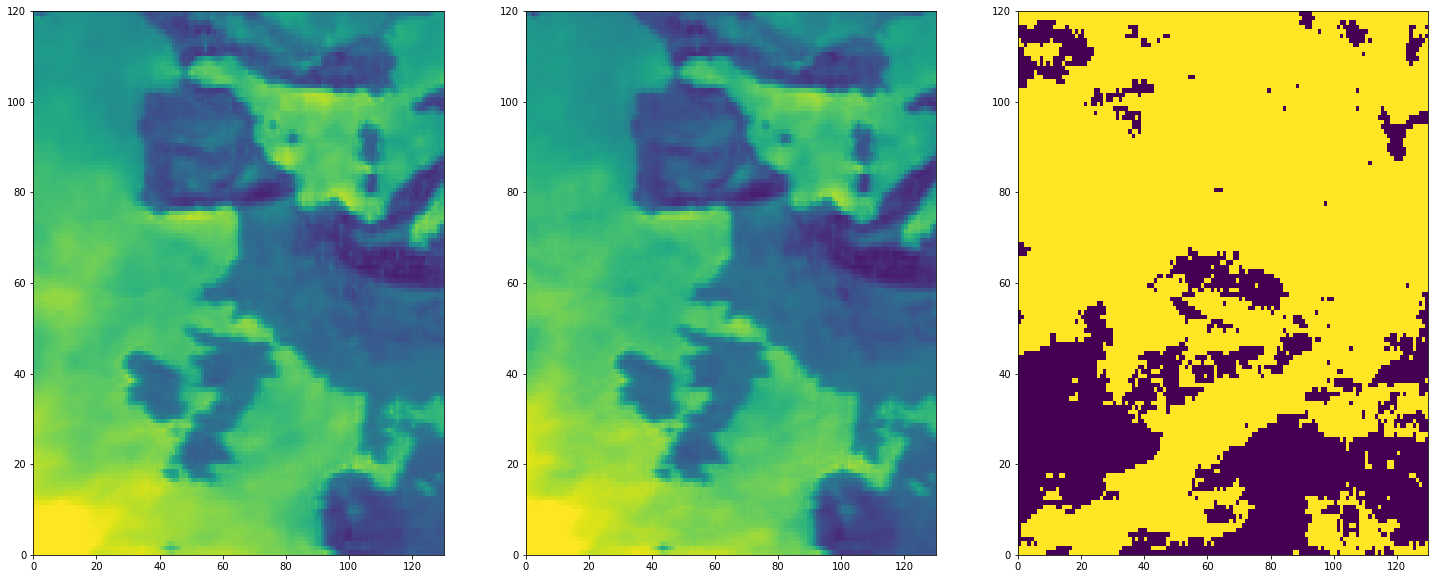

In [82]:
fig, axs = plt.subplots(1,3, figsize = (25,10))
axs.ravel()

axs[0].pcolormesh(crps_ens.mean(axis = 0),vmin = 0, vmax = 0.4)
axs[1].pcolormesh(crps_eq.mean(axis = 0), vmin = 0, vmax = 0.4)
axs[2].pcolormesh(comparison)

In [70]:
crps_ens.min()

0.0015040255280691771